## Fast Gradient Sign Method Attack

Adverserial attack aims at misleading, evading or decieving a machine learning model by introducing small and often imperceptible  perturbations (noise). In this regard, **Fast Gradient Sign Method (FGSM)**, aims at introducing peturbation that optimize the input data to maximize the prediction error of a model. 

The attack is done to introducing a noise along **the direction of the sign of the gradient at _each pixel_**. In other words, the noises are closely aligned with the weight vectors a model is attempting to generlize. Its important to note that the attack simply emulates the **sign** of the elements of the gradient.

In the following example, we will use the python package **foolbox** to apply an attack and observe how it mislead a model trained on the *imagenet* datset.

#### modules and model

In [21]:
import foolbox
import keras
import numpy as np
from keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt

Let's start by insantiating the model and introducing a preprocessing task.

In [ ]:
keras.backend.set_learning_phase(0)
kmodel = ResNet50(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

Next we will get a sample image and label from the imagenet datset.

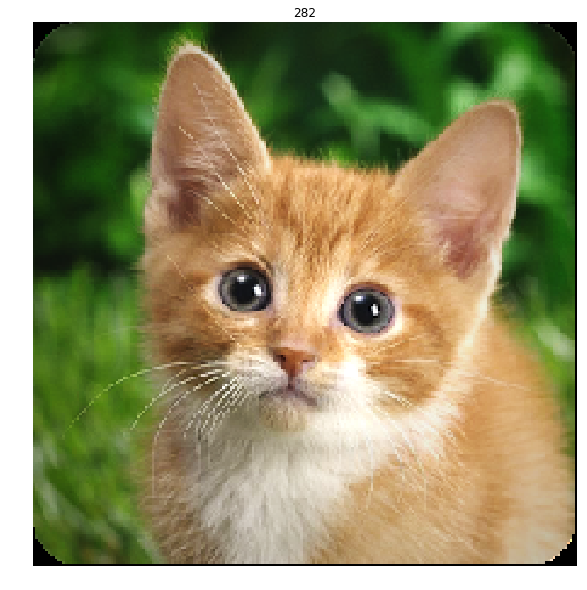

In [120]:
plt.figure(figsize=(10,10))
image, label = foolbox.utils.imagenet_example()
plt.imshow(image/255)
plt.title(label)
plt.axis('off')
plt.show()

### Applying the Attack

Steps:
    - First, call the FGMS attack
    - Second, get the gradient of the model 
    - Third, introduce the attack to the image.


In [30]:
attack = foolbox.attacks.FGSM(fmodel)
adversarial = attack(image[:, :, ::-1], label)

The default value of the attack uses an iterable step sizes of **1000**. This is number of steps the attack iterates in the direction of the sign of the gradient. **::-1** is added to reverse the color channels of the image, because Keras ResNet50 expects BGR instead of RGB. 
Let's take al look at the attack.

In [92]:
difference = adversarial[:, :, ::-1] - image
difference[0:1,0:14]

array([[[0.     , 0.     , 0.     ],
        [0.03825, 0.03825, 0.     ],
        [0.03825, 0.03825, 0.03825],
        [0.03825, 0.03825, 0.03825],
        [0.     , 0.     , 0.     ],
        [0.03825, 0.03825, 0.03825],
        [0.03825, 0.03825, 0.     ],
        [0.03825, 0.03825, 0.03825],
        [0.03825, 0.03825, 0.03825],
        [0.     , 0.     , 0.     ],
        [0.03825, 0.03825, 0.03825],
        [0.03825, 0.     , 0.03825],
        [0.     , 0.     , 0.     ],
        [0.03825, 0.     , 0.     ]]], dtype=float32)

The array shown above is the first 15 values added to the original image by the attack to create an adverserial example. To visualize the values, a little bit of agumentation is needed.

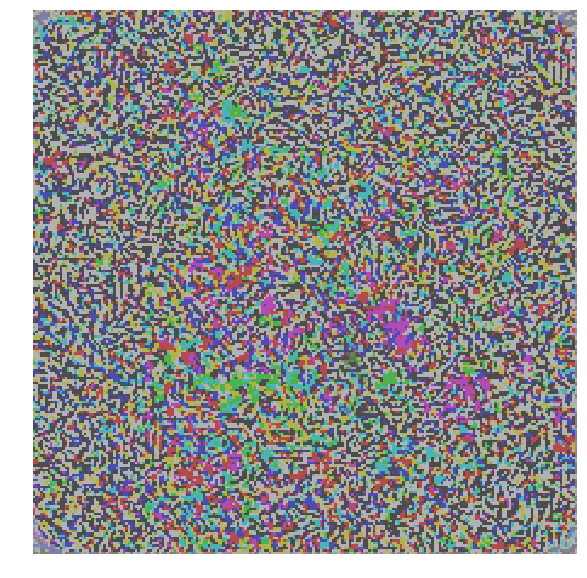

In [119]:
plt.figure(figsize=(10,10))
agumentated_adv = difference / abs(difference).max() * 0.2 + 0.5
plt.imshow(agumentated_adv)
plt.axis('off')
plt.show()

### Did adding this value changed the look of the image? 

Let's answer this question by visualizing adverserial/infected image.

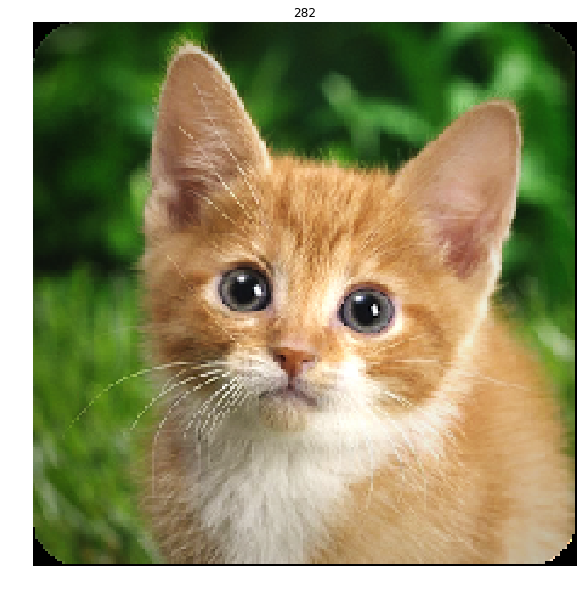

In [118]:
plt.figure(figsize=(10,10))
plt.imshow(adversarial[:, :, ::-1]/255)
plt.title(label)
plt.axis('off')
plt.show()

### Side by side view

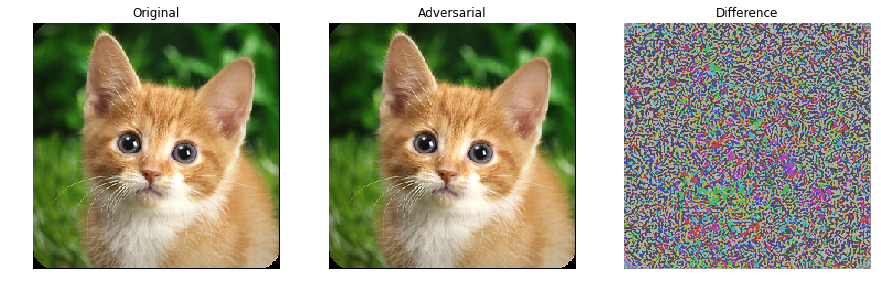

In [128]:
%matplotlib inline

plt.figure(figsize=(15,15))

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(image / 255) 
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adversarial')
plt.imshow(adversarial[:, :, ::-1] / 255)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
difference = adversarial[:, :, ::-1] - image
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.show()

 ### Prediction

Let's use the imagenet model and predict on both the original image and the adverserial example. 
First, change each of the images to a batch format.

In [192]:
original_img_batch = np.expand_dims(image, axis=0)
adveserial_img_batch = np.expand_dims(adversarial, axis=0)

print("original image batch:", (original_image_batch.shape))
print("adveserial_img_batch:", (adveserial_img_batch.shape))

original image batch: (1, 224, 224, 3)
adveserial_img_batch: (1, 224, 224, 3)


In [193]:
from keras.applications.imagenet_utils import decode_predictions

orignal_img_prediction = kmodel.predict_on_batch(original_img_batch)
orignal_img_label = decode_predictions(orignal_img_prediction )

print(orignal_img_label[0])

[('n02127052', 'lynx', 0.4762164), ('n02120079', 'Arctic_fox', 0.08499201), ('n02120505', 'grey_fox', 0.08084935), ('n02123597', 'Siamese_cat', 0.06971976), ('n02124075', 'Egyptian_cat', 0.048190363)]


The model predicts with a 47% accuracy that the original image is a Lynx. Next, unto the fake image.

In [195]:
adveserial_img_prediction = kmodel.predict_on_batch(adveserial_img_batch)
adveserial_img_label = decode_predictions(adveserial_img_prediction)
print(adveserial_img_label)

[[('n02127052', 'lynx', 0.2685563), ('n02123159', 'tiger_cat', 0.20841096), ('n02123045', 'tabby', 0.124287754), ('n02123394', 'Persian_cat', 0.11322261), ('n02124075', 'Egyptian_cat', 0.08708234)]]


Accordingly, the accuracy is now down to at 26%. In fact, there is a 20% chance that the image is a tiget cat.